In [ ]:
#import sys
#!{sys.executable} -m pip install geopandas

In [1]:
import pandas as pd
import sys
import csv
import os
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
default_color = "#2171b5"
csv.field_size_limit(sys.maxsize)

131072

# Data Cleaning 

In [ ]:
def clean():
    
    # Load all datasets
    df_review = pd.read_csv('data/seattle_reviews.csv', sep=None,engine='python')
    df_insp1 = pd.read_csv('data/seattle_instances_mergerd.csv', sep=None,engine='python')
    df_insp2 = pd.read_csv('data/Food_Establishment_Inspection_Data.csv')
    df_insp2 = df_insp2.rename(columns={'Inspection_Serial_Num': 'inspection_id'})
    df_insp = df_insp1.merge(df_insp2,on="inspection_id")
    print(len(df_insp.inspection_id.unique()))
    
    # Convert to datetime object
    df_insp.inspection_period_start_date = pd.to_datetime(df_insp.inspection_period_start_date)
    df_insp.inspection_period_end_date = pd.to_datetime(df_insp.inspection_period_end_date)
    df_review.review_date = pd.to_datetime(df_review.review_date)
    df_insp['inspection_year'] = df_insp["inspection_period_end_date"].dt.year
    df_insp['inspection_month'] = df_insp["inspection_period_end_date"].dt.month
    
    # Remove inpection_score = -1 outlier
    df_insp = df_insp[df_insp.inspection_penalty_score >= 0]
    
    # Merge inspection data with review
    df_merge = pd.merge(df_insp, df_review, on="restaurant_id", how="left")
    
    # Only care about reviews that is commented within inspection rage
    review_lower = (df_merge.review_date >= df_merge.inspection_period_start_date)
    review_upper = (df_merge.review_date <= df_merge.inspection_period_end_date)
    df_merge = df_merge[review_lower & review_upper]
    
    # Convert violation type to categorical code 
    df_merge['Violation Type'] = pd.Categorical(df_merge['Violation Type'])
    df_merge['violation_code'] = df_merge['Violation Type'].cat.codes
    
    # Groupby inspection to extract the most severe violation type
    group = ['inspection_id', 'restaurant_id', 'inspection_period_start_date',
       'inspection_period_end_date', 'inspection_penalty_score',
       'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating', 'review_contents',
       'Program Identifier', 'Inspection Date', 'Description', 'Zip Code',
       'Longitude', 'Latitude', 'Inspection Business Name', 'Inspection Type',
       'Inspection Score', 'Inspection Result', 'Inspection Closed Business',
       'inspection_year','inspection_month', 'review_id', 'review_date', 'rating', 'content']
    
    df_indivd = df_merge.groupby(group, as_index=False).agg(
        {'Violation_Record_ID':'max','violation_code':'max','Violation Points':'mean','Violation Description':'max'})
    df_agg = df_indivd[df_indivd.columns.drop(
        ['review_id', 'review_date', 'rating', 'content'])].drop_duplicates(keep='first')
    print(df_indivd.shape)
    print(df_agg.shape)
    return {'individual':df_indivd,'aggregated':df_agg}

In [ ]:
df = clean()

In [ ]:
df['individual'].to_csv("individual_review_inspection_merged_cleaned.csv")
df['aggregated'].to_csv("aggregated_review_inspection_merged_cleaned.csv")

# Data Exploration - Inspection

In [2]:
df = pd.read_csv('data/individual_review_inspection_merged_cleaned.csv', sep=None,engine='python')
df_agg = pd.read_csv('data/aggregated_review_inspection_merged_cleaned.csv', sep=None,engine='python')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107553 entries, 0 to 107552
Data columns (total 35 columns):
Unnamed: 0                                107553 non-null int64
inspection_id                             107553 non-null object
restaurant_id                             107553 non-null object
inspection_period_start_date              107553 non-null object
inspection_period_end_date                107553 non-null object
inspection_penalty_score                  107553 non-null int64
inspection_average_prev_penalty_scores    107553 non-null float64
inspection_prev_penalty_score             107553 non-null int64
cuisines                                  107553 non-null object
zip_code                                  107553 non-null int64
review_count                              107553 non-null int64
non_positive_review_count                 107553 non-null int64
average_review_rating                     107553 non-null float64
review_contents                           107553

In [4]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 31 columns):
Unnamed: 0                                7703 non-null int64
inspection_id                             7703 non-null object
restaurant_id                             7703 non-null object
inspection_period_start_date              7703 non-null object
inspection_period_end_date                7703 non-null object
inspection_penalty_score                  7703 non-null int64
inspection_average_prev_penalty_scores    7703 non-null float64
inspection_prev_penalty_score             7703 non-null int64
cuisines                                  7703 non-null object
zip_code                                  7703 non-null int64
review_count                              7703 non-null int64
non_positive_review_count                 7703 non-null int64
average_review_rating                     7703 non-null float64
review_contents                           7703 non-null object
Program Identif

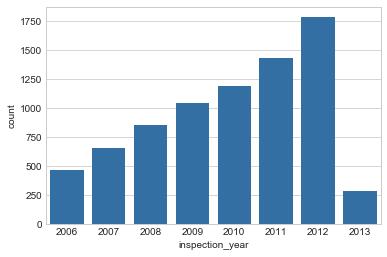

In [38]:
sns.countplot(x=df_agg.inspection_year, data=df_agg, color=default_color)

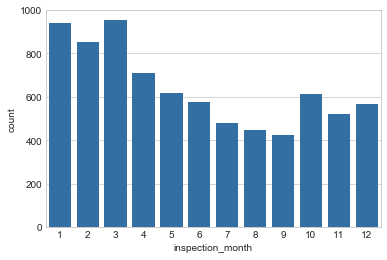

In [6]:
sns.countplot(x=df_agg.inspection_month, data=df_agg, color=default_color)

In [7]:
df.columns

Index(['Unnamed: 0', 'inspection_id', 'restaurant_id',
       'inspection_period_start_date', 'inspection_period_end_date',
       'inspection_penalty_score', 'inspection_average_prev_penalty_scores',
       'inspection_prev_penalty_score', 'cuisines', 'zip_code', 'review_count',
       'non_positive_review_count', 'average_review_rating', 'review_contents',
       'Program Identifier', 'Inspection Date', 'Description', 'Zip Code',
       'Longitude', 'Latitude', 'Inspection Business Name', 'Inspection Type',
       'Inspection Score', 'Inspection Result', 'Inspection Closed Business',
       'inspection_year', 'inspection_month', 'review_id', 'review_date',
       'rating', 'content', 'Violation_Record_ID', 'violation_code',
       'Violation Points', 'Violation Description'],
      dtype='object')

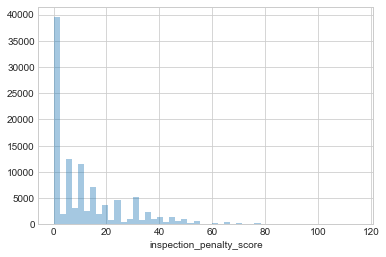

In [44]:
sns.distplot(df.inspection_penalty_score, bins=50, kde=False, rug=False)

In [49]:
no_penalty = df[df.inspection_penalty_score==0].inspection_penalty_score.count()
total_count = df.inspection_penalty_score.count()
no_penalty/total_count # Percent of inspections with no code violations

0.36208195029427354

In [64]:
rest_count = df.restaurant_id.value_counts()

In [ ]:
# Do restaurants with bad ratings have more number of repeated inpsections?

#sns.barplot(x="average_review_rating", y="count_restaurant", data=temp_df[temp_df.count_restaurant>100]);
temp_df = rest_count.to_frame().reset_index().rename(columns={'index':'restaurant_id',"restaurant_id":'count_restaurant'}).merge(df_agg, on= 'restaurant_id')
sns.countplot(x="count_restaurant", hue="average_review_rating", data=temp_df[temp_df.count_restaurant>100], palette="Set2")

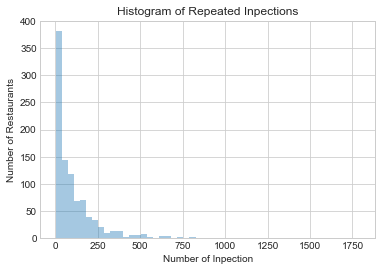

In [10]:
# Repeated inspection
g = sns.distplot(rest_count, kde=False)
g.set(xlabel='Number of Inpection', ylabel='Number of Restaurants')
plt.title("Histogram of Repeated Inpections")
plt.show(g)

0.47067957193197774

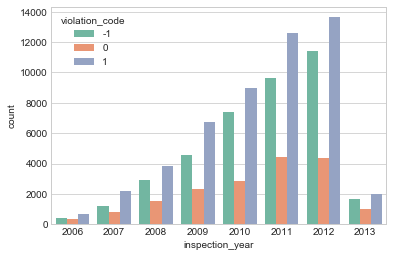

In [96]:
#Inpsection Accuracy
sns.countplot(x="inspection_year", hue="violation_code", data=df, palette="Set2")

#number of times inspected restaurants had a violation
df[df.violation_code ==1].violation_code.count()/df.violation_code.count() 

In [12]:
df[["average_review_rating","inspection_penalty_score"]].corr(method= 'spearman')

,average_review_rating,inspection_penalty_score
average_review_rating,1.000000,-0.061324
inspection_penalty_score,-0.061324,1.000000


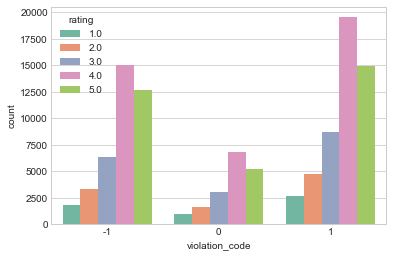

In [13]:
sns.countplot(x="violation_code", hue="rating", data=df, palette="Set2")

In [99]:
#number of times inspected restaurants had a violation
df[df.rating >3].rating.count()

74316

In [14]:
print(df[(df['violation_code'] > 0) & (df['rating'] < 4)].shape)
print(df[(df['violation_code'] <=0) & (df['rating'] > 3)].shape)

(16106, 35)
(39799, 35)


## Review rating is not informative!

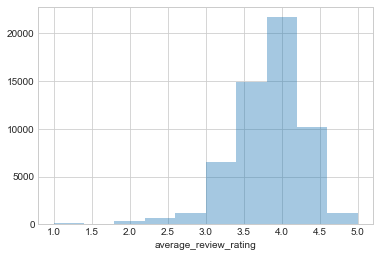

In [100]:
# No code violation restaurant
sns.distplot(df[df["violation_code"!=1]]["average_review_rating"], bins = 10,kde=False)

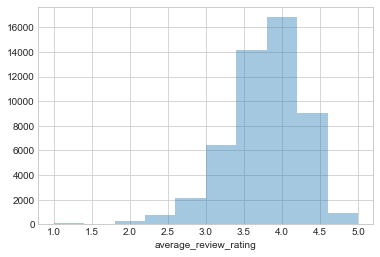

In [101]:
# Code Violation Restaurants
sns.distplot(df[df["violation_code"] == 1]["average_review_rating"], bins = 10,kde=False)

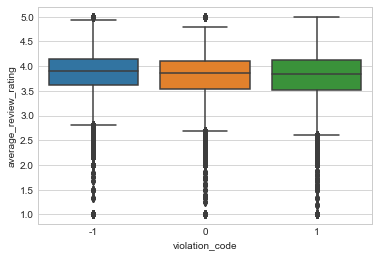

In [118]:
sns.boxplot(x="violation_code", y="average_review_rating", data=df)

In [123]:
corr = []
thresholds = [0,10,20,30,40,50,60,70]
for i in thresholds:
    corr_table = df[df["inspection_penalty_score"] > i][["average_review_rating","inspection_penalty_score"]].corr(method= 'spearman')
    corr.append(corr_table.iloc[0][1])

In [124]:
pprint(corr)

[0.0034598914693042917,
 0.051559495434092169,
 -0.012804133305935501,
 0.015825072272612248,
 0.062548931673852434,
 0.14962126099982404,
 0.081499521345594086,
 -0.1102112105443467]


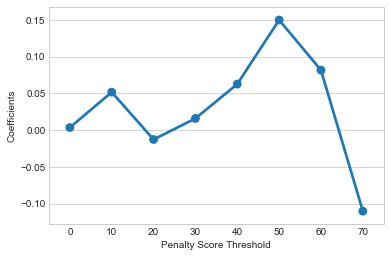

In [125]:
g = sns.pointplot(thresholds, corr)
g.set(xlabel='Penalty Score Threshold', ylabel='Coefficients')
g

**Weird that penalty score positively correlated with average rating**

## Review Count (Positive corr)

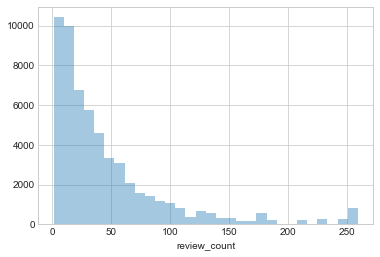

In [119]:
#Restaurants with no code violations
sns.distplot(df[df["violation_code"] !=1]["review_count"], bins = 30,kde=False)

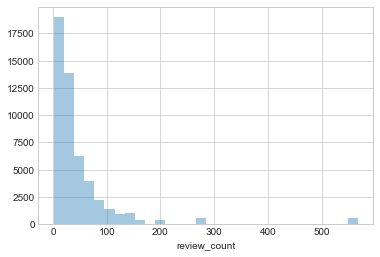

In [120]:
#Restaurants with  violations
sns.distplot(df[df["violation_code"] == 1]["review_count"], bins = 30,kde=False)

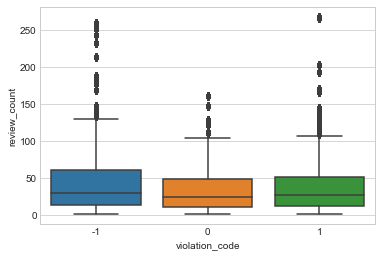

In [126]:
sns.boxplot(x="violation_code", y="review_count", data=df[df.review_count<500])

In [22]:
corr = []
thresholds = [0,10,20,30,40,50,60]
for i in thresholds:
    corr_table = df[df["inspection_penalty_score"] > i][["review_count","inspection_penalty_score"]].corr(method= 'spearman')
    corr.append(corr_table.iloc[0][1])

In [23]:
corr

[0.03120357044344094,
 0.078589059279240786,
 0.02803130983675637,
 0.045416392274639741,
 0.062110715944546209,
 0.27378437425888436,
 -0.045617907901653938]

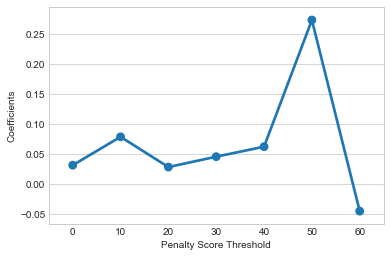

In [24]:
g = sns.pointplot(thresholds, corr)
g.set(xlabel='Penalty Score Threshold', ylabel='Coefficients')
g

## Geo Distribution

In [30]:
import geopandas as gpd

In [32]:
map = gpd.read_file("data/zip-codes.geojson")

In [33]:
map['GEOID10'] = pd.to_numeric(map['GEOID10'])

In [34]:
vc = df[df["inspection_penalty_score"] > 0]["zip_code"].value_counts()
counts = pd.DataFrame({'GEOID10':vc.index, 'count':vc.values})

In [35]:
heatmap = pd.merge(map, counts, on = "GEOID10",how="left")

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


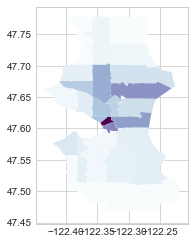

In [36]:
heatmap.plot(column='count',cmap='BuPu')

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


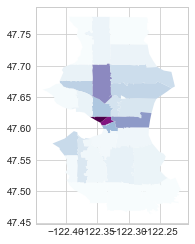

In [127]:
#No Violation Restaurants
vc = df[df["violation_code"] != 1]["zip_code"].value_counts()
counts = pd.DataFrame({'GEOID10':vc.index, 'count':vc.values})
heatmap = pd.merge(map, counts, on = "GEOID10",how="left")
heatmap.plot(column='count',cmap='BuPu')

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


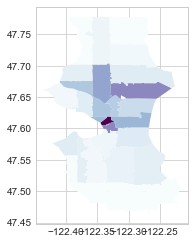

In [128]:
# Violation Restaurants
vc = df[df["violation_code"] == 1]["zip_code"].value_counts()
counts = pd.DataFrame({'GEOID10':vc.index, 'count':vc.values})
heatmap = pd.merge(map, counts, on = "GEOID10",how="left")
heatmap.plot(column='count',cmap='BuPu')

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


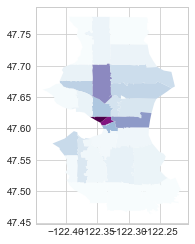

In [129]:
#All restaurants
vc = df[df["violation_code"] != 1]["zip_code"].value_counts()
counts = pd.DataFrame({'GEOID10':vc.index, 'count':vc.values})
heatmap = pd.merge(map, counts, on = "GEOID10",how="left")
heatmap.plot(column='count',cmap='BuPu')